In [ ]:
# Classifications VICT et NSW
# 1) importer les modules nécessaires
# 2) lire les fichiers et concaténer les deux trames de données
# 3) Analyse sur NSW (régression logistique, KNN, random Forest)
# 4) Analyse sur VIC (régression logistique, KNN, forêt aléatoire)
# 5) Analyse sur VIC + NSW (régression logistique, KNN, random Forest)

# Notez que:
# la méthode de régression logistique ne converge pas, même en augmentant le nombre d'itérations.
# le meilleur et le KNN 
# Les données n'ont pas été traitées avec OVERSAMPLING en raison des limitations de mon ordinateur.


In [1]:
%run Code_Commun.ipynb

In [6]:
df_NSW = pd.read_csv('WeatherAUSRegionNSW.csv', sep =';')
df_NSW.head(5)

df_VIC = pd.read_csv('WeatherAUSRegionVIC.csv', sep=';')
df_VIC.head(5)

frames = [df_NSW, df_VIC]
df_NSW_VIC = pd.concat(frames)
df_NSW_VIC.isnull().sum()

Location         0
MinTemp          0
MaxTemp          0
Rainfall         0
Evaporation      0
Sunshine         0
WindGustDir      0
WindGustSpeed    0
Humidity9am      0
Humidity3pm      0
Pressure9am      0
Pressure3pm      0
RainToday        0
RainTomorrow     0
year             0
month            0
day              0
week             0
Radar            0
Region           0
dtype: int64

In [7]:
ReplaceRain(df_NSW)
df_NSW=GetDummies(df_NSW, 'WindGustDir')
df_NSW=GetDummies(df_NSW, 'Location')
df_NSW=GetDummies(df_NSW, 'Region')
df_NSW=GetDummies(df_NSW, 'Radar')

Variables remplacées


In [8]:
df_std_NSW = df_NSW
num_var = df_std_NSW.select_dtypes(include = 'float64')
num = num_var.columns
# on ne prend pas les 'int64', car ces variables correspondent à year, month, day
#Standardisation:
df_std_NSW[num]=Standardise(df_std_NSW,num)

df_std_NSW.head()


,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,...,SydneyAirport,Tuggeranong,WaggaWagga,Williamtown,Wollongong,New South Wales,Brisbane,Hobart,SydneyAirport,isole
0,-0.111631,0.567691,-0.28777,1.206001,1.455329,1.111089,-1.365084,-1.303579,-2.028463,-1.870944,...,0,0,0,0,0,1,0,0,1,0
1,-0.375300,0.184047,-0.28777,1.534829,-0.384200,0.064177,-1.478542,-1.495724,-0.579421,-0.406814,...,0,0,0,0,0,1,0,0,1,0
2,-0.235710,0.907068,-0.28777,0.986783,-1.803266,-0.982734,-1.535272,-1.495724,0.049961,-0.155397,...,0,0,0,0,0,1,0,0,1,0
3,0.043469,1.762889,-0.28777,0.000298,1.034865,-0.214999,-1.648730,-1.976087,-0.476964,-0.820911,...,0,0,0,0,0,1,0,0,1,0
4,0.136529,1.939956,-0.28777,1.260806,1.271376,0.064177,-1.648730,-2.120196,-0.842883,-0.983592,...,0,0,0,0,0,1,0,0,1,0


In [9]:
target_NSW = df_std_NSW['RainTomorrow']
data_NSW = df_std_NSW.drop('RainTomorrow', axis = 1)


In [10]:
X_train, X_test, y_train, y_test = train_test_split(data_NSW, target_NSW, test_size = 0.2, random_state = 66)

In [11]:
# ===== OverSampling
rOs = RandomOverSampler()
X_ro, y_ro = rOs.fit_resample(X_train, y_train)
print('Classes échantillon oversampled :', dict(pd.Series(y_ro).value_counts()))

Classes échantillon oversampled : {0: 30475, 1: 30475}


In [ ]:
#********* IMPORTANT
#********* JE N'AI PAS UTILISÉ LE SURÉCHANTILLONNAGE CAR IL EST TROP LOURD POUR MON ORDINATEUR. 
# ********* LORSQUE J'EFFECTUE LE CALCUL AVEC LA RÉGRESSION LOGISTIQUE ET KNN 

#PAS DE SURÉCHANTILLONNAGE
#from imblearn.over_sampling import RandomOverSampler
#rOs = RandomOverSampler()
#X_ro, y_ro = rOs.fit_sample(X_train, y_train)
#print('Classes échantillon oversampled :', dict(pd.Series(y_ro).value_counts()))

In [93]:
# instanciation d'une méthode simple 

lr = LogisticRegression() # testé aussi itération max = 10000 et tollerance : 0.01, 0.001, 1e 0.0001 mais ça ne marche pas.
lr.fit(X_ro, y_ro)


# comme paramètres C j'ai utilisé les 9 premiers nombres de la série de fibonacci en négligeant le premier nombre 
# (puisqu'il est égal au second), mais j'ai inséré 0.1 au lieu de 1.
# J'ai aussi utilisé différentes méthodes de résolution 

parameters = {'C':[0.1, 1, 2, 3, 5, 8, 13, 21, 34],
              'solver':['sag', 'saga', 'lbfgs'],
             'random_state' : [66]}

grid_lr_NSW = model_selection.GridSearchCV(estimator=lr, param_grid=parameters)
grille = grid_lr_NSW.fit(X_ro, y_ro)
print(pd.DataFrame.from_dict(grille.cv_results_).loc[:,['params', 'mean_test_score']])

print ('Best params:', grid_lr_NSW.best_params_)

#solver='lbfgs'


/Users/bernardinotirri/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/Users/bernardinotirri/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/Users/bernardinotirri/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/Users/bernardinotirri/opt/anaconda3/

                           params  mean_test_score
0     {'C': 0.1, 'solver': 'sag'}         0.819890
1    {'C': 0.1, 'solver': 'saga'}         0.789821
2   {'C': 0.1, 'solver': 'lbfgs'}         0.837942
3       {'C': 1, 'solver': 'sag'}         0.820145
4      {'C': 1, 'solver': 'saga'}         0.789719
5     {'C': 1, 'solver': 'lbfgs'}         0.836847
6       {'C': 2, 'solver': 'sag'}         0.819839
7      {'C': 2, 'solver': 'saga'}         0.789821
8     {'C': 2, 'solver': 'lbfgs'}         0.837483
9       {'C': 3, 'solver': 'sag'}         0.819864
10     {'C': 3, 'solver': 'saga'}         0.789923
11    {'C': 3, 'solver': 'lbfgs'}         0.837152
12      {'C': 5, 'solver': 'sag'}         0.819992
13     {'C': 5, 'solver': 'saga'}         0.789897
14    {'C': 5, 'solver': 'lbfgs'}         0.838502
15      {'C': 8, 'solver': 'sag'}         0.819992
16     {'C': 8, 'solver': 'saga'}         0.789897
17    {'C': 8, 'solver': 'lbfgs'}         0.838095
18     {'C': 13, 'solver': 'sag

/Users/bernardinotirri/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


In [42]:
y_pred = lr.predict(X_test)
pd.crosstab(y_test, y_pred, rownames = ['Classe Réelle'], colnames = ['Classe Prédite'])


Classe Prédite,0,1
Classe Réelle,,
0,7226,437
1,1139,1018


In [15]:
knn = neighbors.KNeighborsClassifier()
param_knn ={'n_neighbors': [1, 2, 3, 5, 8, 13, 21, 34, 55],
            'metric':['euclidean', 'minkowski', 'manhattan']}

grid_knn_NSW = model_selection.GridSearchCV(estimator=knn, param_grid=param_knn)
grille_knn = grid_knn_NSW.fit(X_ro, y_ro)

print(pd.DataFrame.from_dict(grille_knn.cv_results_).loc[:,['param_metric', 'param_n_neighbors','mean_test_score']])
df_grille_knn = pd.DataFrame.from_dict(grille_knn.cv_results_).loc[:,['param_metric', 'param_n_neighbors','mean_test_score']]

print ('****************************************************************************')
print()
print ('Best params:', grid_knn_NSW.best_params_)
print ()
print ('****************************************************************************')



   param_metric param_n_neighbors  mean_test_score
0     euclidean                 1         0.937588
1     euclidean                 2         0.906612
2     euclidean                 3         0.884282
3     euclidean                 5         0.858080
4     euclidean                 8         0.845283
5     euclidean                13         0.830041
6     euclidean                21         0.813716
7     euclidean                34         0.800492
8     euclidean                55         0.786891
9     minkowski                 1         0.937588
10    minkowski                 2         0.906612
11    minkowski                 3         0.884282
12    minkowski                 5         0.858080
13    minkowski                 8         0.845283
14    minkowski                13         0.830041
15    minkowski                21         0.813716
16    minkowski                34         0.800492
17    minkowski                55         0.786891
18    manhattan                

In [16]:
knn = neighbors.KNeighborsClassifier(metric ='manhattan', 
                                     n_neighbors = 1)

knn.fit(X_ro,y_ro)

KNeighborsClassifier(metric='manhattan', n_neighbors=1)

In [17]:
y_pred_knn_NSW = knn.predict(X_test)
pd.crosstab(y_test, y_pred_knn_NSW, rownames = ['Classe Réelle'], colnames = ['Classe Prédite'])
print(classification_report(y_pred_knn_NSW,y_test))
print('accuracy_score',accuracy_score(y_pred_knn_NSW, y_test))

              precision    recall  f1-score   support

           0       0.90      0.89      0.89      7750
           1       0.60      0.62      0.61      2070

    accuracy                           0.83      9820
   macro avg       0.75      0.76      0.75      9820
weighted avg       0.84      0.83      0.83      9820

accuracy_score 0.8326883910386965


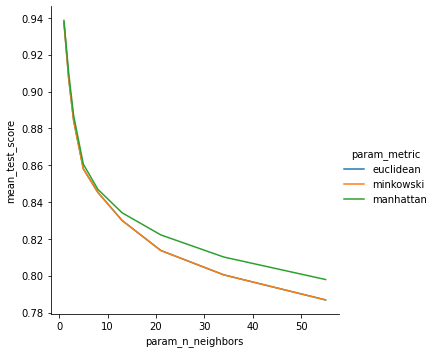

In [18]:
sns.relplot(x= 'param_n_neighbors', y = 'mean_test_score' , hue='param_metric', data=df_grille_knn, kind='line' );
# manhattan overlap euclidean

In [19]:
clfrf_NSW = ensemble.RandomForestClassifier(n_jobs=-1,
                                            random_state=66, 
                                            criterion = 'gini', 
                                            max_depth = 8, 
                                            max_features = 'log2',
                                            n_estimators = 500)
                                               
clfrf_NSW.fit(X_ro,y_ro)


RandomForestClassifier(max_depth=8, max_features='log2', n_estimators=500,
                       n_jobs=-1, random_state=66)

In [23]:
y_pred_clfrf_NSW = clfrf_NSW.predict(X_test)
pd.crosstab(y_test, y_pred_clfrf_NSW, rownames = ['Classe Réelle'], colnames = ['Classe Prédite'])


Classe Prédite,0,1
Classe Réelle,,
0,6182,1481
1,549,1608


In [24]:
print(classification_report(y_pred_clfrf_NSW,y_test))
print('accuracy_score',accuracy_score(y_pred_clfrf_NSW, y_test))

              precision    recall  f1-score   support

           0       0.81      0.92      0.86      6731
           1       0.75      0.52      0.61      3089

    accuracy                           0.79      9820
   macro avg       0.78      0.72      0.74      9820
weighted avg       0.79      0.79      0.78      9820

accuracy_score 0.7932790224032586


In [ ]:
################## VICTORIA DATA SET ################################

In [25]:


df_VIC.dropna(axis=0, how='any', subset=['RainToday','RainTomorrow'], inplace=True)

ReplaceRain(df_VIC)
df_VIC=GetDummies(df_VIC, 'WindGustDir')
df_VIC=GetDummies(df_VIC, 'Location')
df_VIC=GetDummies(df_VIC, 'Region')
df_VIC=GetDummies(df_VIC, 'Radar')

df_std_VIC = df_VIC
num_var = df_std_VIC.select_dtypes(include = 'float64')
num = num_var.columns

# on ne prend pas les 'int64', car ces variables correspondent à year, month, day
#Standardisation:
df_std_VIC[num]=Standardise(df_std_VIC,num)


Variables remplacées


In [26]:
target_VIC = df_std_VIC['RainTomorrow']
data_VIC = df_std_VIC.drop('RainTomorrow', axis = 1)


In [44]:
X_train, X_test, y_train, y_test = train_test_split(data_VIC, target_VIC, test_size = 0.2, random_state = 66)

In [45]:
# ===== OverSampling
rOs = RandomOverSampler()
X_ro, y_ro = rOs.fit_resample(X_train, y_train)
print('Classes échantillon oversampled :', dict(pd.Series(y_ro).value_counts()))

Classes échantillon oversampled : {0: 13978, 1: 13978}


In [58]:
# instanciation d'une méthode simple 

lr_VIC = LogisticRegression() # testé aussi itération max = 10000 et tollerance : 0.01, 0.001, 1e 0.0001 mais ça ne marche pas.
lr_VIC.fit(X_train, y_train)


# comme paramètres C j'ai utilisé les 9 premiers nombres de la série de fibonacci en négligeant le premier nombre 
# (puisqu'il est égal au second), mais j'ai inséré 0.1 au lieu de 1.
# J'ai aussi utilisé différentes méthodes de résolution 

parameters = {'C':[0.1, 1, 2, 3, 5, 8, 13, 21, 34],
              'solver':['sag', 'saga', 'lbfgs']}

grid_lr_VIC = model_selection.GridSearchCV(estimator=lr_VIC, param_grid=parameters)
grille_VIC = grid_lr_VIC.fit(X_ro, y_ro)
print(pd.DataFrame.from_dict(grille_VIC.cv_results_).loc[:,['params', 'mean_test_score']])

print ('****************************************************************************')
print()
print ('Best params:', grid_lr_VIC.best_params_)
print ()
print ('****************************************************************************')


/Users/bernardinotirri/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/Users/bernardinotirri/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/Users/bernardinotirri/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/Users/bernardinotirri/opt/anaconda3/

                           params  mean_test_score
0     {'C': 0.1, 'solver': 'sag'}         0.791221
1    {'C': 0.1, 'solver': 'saga'}         0.763568
2   {'C': 0.1, 'solver': 'lbfgs'}         0.840061
3       {'C': 1, 'solver': 'sag'}         0.791275
4      {'C': 1, 'solver': 'saga'}         0.763623
5     {'C': 1, 'solver': 'lbfgs'}         0.840876
6       {'C': 2, 'solver': 'sag'}         0.790895
7      {'C': 2, 'solver': 'saga'}         0.763514
8     {'C': 2, 'solver': 'lbfgs'}         0.838268
9       {'C': 3, 'solver': 'sag'}         0.791112
10     {'C': 3, 'solver': 'saga'}         0.763568
11    {'C': 3, 'solver': 'lbfgs'}         0.840387
12      {'C': 5, 'solver': 'sag'}         0.791275
13     {'C': 5, 'solver': 'saga'}         0.763460
14    {'C': 5, 'solver': 'lbfgs'}         0.840767
15      {'C': 8, 'solver': 'sag'}         0.791166
16     {'C': 8, 'solver': 'saga'}         0.763460
17    {'C': 8, 'solver': 'lbfgs'}         0.838920
18     {'C': 13, 'solver': 'sag

/Users/bernardinotirri/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


In [46]:
knn_VIC = neighbors.KNeighborsClassifier()
param_knn ={'n_neighbors': [1, 2, 3, 5, 8, 13, 21, 34, 55],
            'metric':['euclidean', 'minkowski', 'manhattan']}

grid_knn_VIC = model_selection.GridSearchCV(estimator=knn_VIC, param_grid=param_knn)
grille_knn_VIC = grid_knn_VIC.fit(X_ro, y_ro)

print(pd.DataFrame.from_dict(grille_knn_VIC.cv_results_).loc[:,['param_metric', 'param_n_neighbors','mean_test_score']])
df_grille_knn_VIC = pd.DataFrame.from_dict(grille_knn_VIC.cv_results_).loc[:,['param_metric', 'param_n_neighbors','mean_test_score']]

print ('****************************************************************************')
print()
print ('Best params:', grid_knn_VIC.best_params_)
print ()
print ('****************************************************************************')


   param_metric param_n_neighbors  mean_test_score
0     euclidean                 1         0.928030
1     euclidean                 2         0.896731
2     euclidean                 3         0.875340
3     euclidean                 5         0.851445
4     euclidean                 8         0.842360
5     euclidean                13         0.831593
6     euclidean                21         0.819788
7     euclidean                34         0.804013
8     euclidean                55         0.788739
9     minkowski                 1         0.928030
10    minkowski                 2         0.896731
11    minkowski                 3         0.875340
12    minkowski                 5         0.851445
13    minkowski                 8         0.842360
14    minkowski                13         0.831593
15    minkowski                21         0.819788
16    minkowski                34         0.804013
17    minkowski                55         0.788739
18    manhattan                

In [47]:
knn = neighbors.KNeighborsClassifier(metric ='manhattan', 
                                     n_neighbors = 1)

knn.fit(X_ro,y_ro)

KNeighborsClassifier(metric='manhattan', n_neighbors=1)

In [48]:
y_pred_knn_VIC = knn.predict(X_test)
pd.crosstab(y_test, y_pred_knn_VIC, rownames = ['Classe Réelle'], colnames = ['Classe Prédite'])


Classe Prédite,0,1
Classe Réelle,,
0,3107,387
1,462,646


In [49]:
print(classification_report(y_pred_knn_VIC,y_test))
print('accuracy_score',accuracy_score(y_pred_knn_VIC, y_test))

              precision    recall  f1-score   support

           0       0.89      0.87      0.88      3569
           1       0.58      0.63      0.60      1033

    accuracy                           0.82      4602
   macro avg       0.74      0.75      0.74      4602
weighted avg       0.82      0.82      0.82      4602

accuracy_score 0.8155149934810951


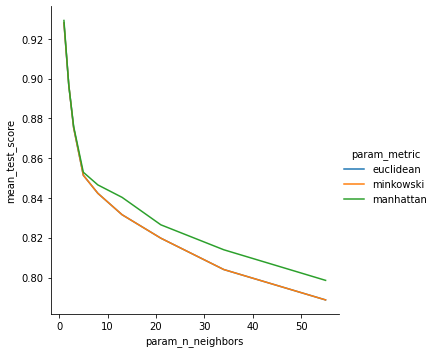

In [50]:
sns.relplot(x= 'param_n_neighbors', y = 'mean_test_score' , hue='param_metric', data=df_grille_knn_VIC, kind='line' );
# manhattan overlap euclidean

In [29]:
clfrf_VIC = ensemble.RandomForestClassifier(n_jobs=-1,
                                            random_state=66, 
                                            criterion = 'gini', 
                                            max_depth = 8, 
                                            max_features = 'log2',
                                            n_estimators = 500)
                                               
clfrf_VIC.fit(X_ro,y_ro)

RandomForestClassifier(max_depth=8, max_features='log2', n_estimators=500,
                       n_jobs=-1, random_state=66)

In [30]:
y_pred_clfrf_VIC = clfrf_VIC.predict(X_test)
pd.crosstab(y_test, y_pred_clfrf_VIC, rownames = ['Classe Réelle'], colnames = ['Classe Prédite'])

Classe Prédite,0,1
Classe Réelle,,
0,2879,615
1,249,859


In [31]:
print(classification_report(y_pred_clfrf_VIC,y_test))
print('accuracy_score',accuracy_score(y_pred_clfrf_VIC, y_test))

              precision    recall  f1-score   support

           0       0.82      0.92      0.87      3128
           1       0.78      0.58      0.67      1474

    accuracy                           0.81      4602
   macro avg       0.80      0.75      0.77      4602
weighted avg       0.81      0.81      0.80      4602

accuracy_score 0.8122555410691004


In [81]:
################## VICTORIA DATA SET and NSW   ################################

In [32]:
ReplaceRain(df_NSW_VIC)
df_NSW_VIC=GetDummies(df_NSW_VIC, 'WindGustDir')
df_NSW_VIC=GetDummies(df_NSW_VIC, 'Location')
df_NSW_VIC=GetDummies(df_NSW_VIC, 'Region')
df_NSW_VIC=GetDummies(df_NSW_VIC, 'Radar')

df_NSW_VIC.info()



Variables remplacées
<class 'pandas.core.frame.DataFrame'>
Int64Index: 72105 entries, 0 to 23008
Data columns (total 65 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   MinTemp           72105 non-null  float64
 1   MaxTemp           72105 non-null  float64
 2   Rainfall          72105 non-null  float64
 3   Evaporation       72105 non-null  float64
 4   Sunshine          72105 non-null  float64
 5   WindGustSpeed     72105 non-null  float64
 6   Humidity9am       72105 non-null  float64
 7   Humidity3pm       72105 non-null  float64
 8   Pressure9am       72105 non-null  float64
 9   Pressure3pm       72105 non-null  float64
 10  RainToday         72105 non-null  int64  
 11  RainTomorrow      72105 non-null  int64  
 12  year              72105 non-null  int64  
 13  month             72105 non-null  int64  
 14  day               72105 non-null  int64  
 15  week              72105 non-null  int64  
 16  E                 7

In [33]:
df_std_NSW_VIC = df_NSW_VIC
num_var = df_std_NSW_VIC.select_dtypes(include = 'float64')
num = num_var.columns

# on ne prend pas les 'int64', car ces variables correspondent à year, month, day
#Standardisation:
df_std_NSW_VIC[num]=Standardise(df_std_NSW_VIC,num)
df_std_NSW_VIC.isnull().sum()

MinTemp             0
MaxTemp             0
Rainfall            0
Evaporation         0
Sunshine            0
                   ..
Hobart              0
MelbourneAirport    0
MountGambier        0
SydneyAirport       0
isole               0
Length: 65, dtype: int64

In [34]:
target_NSW_VIC = df_std_NSW_VIC['RainTomorrow']
data_NSW_VIC = df_std_NSW_VIC.drop('RainTomorrow', axis = 1)

In [35]:
X_train, X_test, y_train, y_test = train_test_split(data_NSW_VIC, target_NSW_VIC, test_size = 0.2, random_state = 66)


In [36]:
# ===== OverSampling
rOs = RandomOverSampler()
X_ro, y_ro = rOs.fit_resample(X_train, y_train)
print('Classes échantillon oversampled :', dict(pd.Series(y_ro).value_counts()))

Classes échantillon oversampled : {0: 44488, 1: 44488}


In [9]:
lr = LogisticRegression() # testé aussi itération max = 10000 et tollerance : 0.01, 0.001, 1e 0.0001 mais ça ne marche pas.
lr.fit(X_ro, y_ro)


# comme paramètres C j'ai utilisé les 9 premiers nombres de la série de fibonacci en négligeant le premier nombre 
# (puisqu'il est égal au second), mais j'ai inséré 0.1 au lieu de 1.
# J'ai aussi utilisé différentes méthodes de résolution 

parameters = {'C':[0.1, 1, 2, 3, 5, 8, 13, 21, 34],
              'solver':['sag', 'saga', 'lbfgs']}

grid_lr_NSW = model_selection.GridSearchCV(estimator=lr, param_grid=parameters)
grille = grid_lr_NSW.fit(X_ro, y_ro)
print(pd.DataFrame.from_dict(grille.cv_results_).loc[:,['params', 'mean_test_score']])

print ('Best params:', grid_lr_NSW.best_params_)


/Users/bernardinotirri/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/Users/bernardinotirri/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/Users/bernardinotirri/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/Users/bernardinotirri/opt/anaconda3/

                           params  mean_test_score
0     {'C': 0.1, 'solver': 'sag'}         0.826815
1    {'C': 0.1, 'solver': 'saga'}         0.806706
2   {'C': 0.1, 'solver': 'lbfgs'}         0.836263
3       {'C': 1, 'solver': 'sag'}         0.826798
4      {'C': 1, 'solver': 'saga'}         0.806758
5     {'C': 1, 'solver': 'lbfgs'}         0.834686
6       {'C': 2, 'solver': 'sag'}         0.826728
7      {'C': 2, 'solver': 'saga'}         0.806792
8     {'C': 2, 'solver': 'lbfgs'}         0.835760
9       {'C': 3, 'solver': 'sag'}         0.826832
10     {'C': 3, 'solver': 'saga'}         0.806740
11    {'C': 3, 'solver': 'lbfgs'}         0.835622
12      {'C': 5, 'solver': 'sag'}         0.826884
13     {'C': 5, 'solver': 'saga'}         0.806688
14    {'C': 5, 'solver': 'lbfgs'}         0.835899
15      {'C': 8, 'solver': 'sag'}         0.826850
16     {'C': 8, 'solver': 'saga'}         0.806636
17    {'C': 8, 'solver': 'lbfgs'}         0.835535
18     {'C': 13, 'solver': 'sag

/Users/bernardinotirri/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


In [16]:

lr_NSW_VIC = LogisticRegression(C=0.1, solver='lbfgs') 
lr_NSW_VIC.fit(X_ro, y_ro)

y_pred_lr_NSW_VIC = lr_NSW_VIC.predict(X_test)
pd.crosstab(y_test, y_pred_lr_NSW_VIC, rownames = ['Classe Réelle'], colnames = ['Classe Prédite'])



/Users/bernardinotirri/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


Classe Prédite,0,1
Classe Réelle,,
0,10457,665
1,1717,1582


In [18]:
from sklearn.metrics import cohen_kappa_score
cohen_kappa_score(y_test, y_pred_lr_NSW_VIC)

0.4727681358816671

In [40]:
knn_NSW_VIC = neighbors.KNeighborsClassifier()
param_knn ={'n_neighbors': [1, 2, 3, 5, 8, 13, 21, 34, 55],
            'metric':['euclidean', 'minkowski', 'manhattan']}

grid_knn_NSW_VIC = model_selection.GridSearchCV(estimator=knn_NSW_VIC, param_grid=param_knn)
grille_knn_NSW_VIC = grid_knn_NSW_VIC.fit(X_ro, y_ro)

print(pd.DataFrame.from_dict(grille_knn_NSW_VIC.cv_results_).loc[:,['param_metric', 'param_n_neighbors','mean_test_score']])
df_grille_knn_NSW_VIC = pd.DataFrame.from_dict(grille_knn_NSW_VIC.cv_results_).loc[:,['param_metric', 'param_n_neighbors','mean_test_score']]

print ('****************************************************************************')
print ()
print ('Best params:', grid_knn_NSW_VIC.best_params_)
print ()
print ('****************************************************************************')




   param_metric param_n_neighbors  mean_test_score
0     euclidean                 1         0.933892
1     euclidean                 2         0.902918
2     euclidean                 3         0.883306
3     euclidean                 5         0.858063
4     euclidean                 8         0.846768
5     euclidean                13         0.833236
6     euclidean                21         0.819468
7     euclidean                34         0.806555
8     euclidean                55         0.792304
9     minkowski                 1         0.933892
10    minkowski                 2         0.902918
11    minkowski                 3         0.883306
12    minkowski                 5         0.858063
13    minkowski                 8         0.846768
14    minkowski                13         0.833236
15    minkowski                21         0.819468
16    minkowski                34         0.806555
17    minkowski                55         0.792304
18    manhattan                

In [41]:
knn_NSW_VIC = neighbors.KNeighborsClassifier(metric='manhattan', n_neighbors= 1 )
knn_NSW_VIC.fit(X_ro, y_ro)
y_pred_knn_NSW_VIC = knn_NSW_VIC.predict(X_test)
pd.crosstab(y_test, y_pred_knn_NSW_VIC, rownames = ['Classe Réelle'], colnames = ['Classe Prédite'])


Classe Prédite,0,1
Classe Réelle,,
0,9979,1143
1,1330,1969


In [42]:
print(classification_report(y_pred_knn_NSW_VIC,y_test))
print('accuracy_score',accuracy_score(y_pred_knn_NSW_VIC, y_test))

              precision    recall  f1-score   support

           0       0.90      0.88      0.89     11309
           1       0.60      0.63      0.61      3112

    accuracy                           0.83     14421
   macro avg       0.75      0.76      0.75     14421
weighted avg       0.83      0.83      0.83     14421

accuracy_score 0.8285139726787324


In [43]:
#from sklearn.metrics import cohen_kappa_score
#cohen_kappa_score(y_test, y_pred_knn_NSW_VIC)
print ('Recall score:',     recall_score(y_test, y_pred_knn_NSW_VIC))
print ('Accuracy score:',   accuracy_score(y_test, y_pred_knn_NSW_VIC))
print ('Preccision score:', precision_score(y_test, y_pred_knn_NSW_VIC))
print ('F1 score:',         f1_score(y_test, y_pred_knn_NSW_VIC))

Recall score: 0.5968475295544104
Accuracy score: 0.8285139726787324
Preccision score: 0.6327120822622108
F1 score: 0.6142567462174388


In [ ]:
#### random FOREST

In [37]:
#### PARAMETERS FITTED ON ISLE
clfrf_NSW_VIC = ensemble.RandomForestClassifier(n_jobs=-1,
                                            random_state=66, 
                                            criterion = 'gini', 
                                            max_depth = 8, 
                                            max_features = 'log2',
                                            n_estimators = 500)
                                               
clfrf_NSW_VIC.fit(X_ro,y_ro)

RandomForestClassifier(max_depth=8, max_features='log2', n_estimators=500,
                       n_jobs=-1, random_state=66)

In [38]:
y_clfrf_NSW_VIC = clfrf_NSW_VIC.predict(X_test)
pd.crosstab(y_test, y_clfrf_NSW_VIC, rownames = ['Classe Réelle'], colnames = ['Classe Prédite'])

Classe Prédite,0,1
Classe Réelle,,
0,8838,2284
1,784,2515


In [39]:
print(classification_report(y_clfrf_NSW_VIC,y_test))
print('accuracy_score',accuracy_score(y_clfrf_NSW_VIC, y_test))

              precision    recall  f1-score   support

           0       0.79      0.92      0.85      9622
           1       0.76      0.52      0.62      4799

    accuracy                           0.79     14421
   macro avg       0.78      0.72      0.74     14421
weighted avg       0.78      0.79      0.78     14421

accuracy_score 0.7872546980098467
